# Classic

In [ ]:
!pip3 install ipywidgets

In [1]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [ ]:
##use csv2npz to create npz which is called newdata.npz

In [ ]:
#from src.newsrc.utils import csv2npz

#csv2npz('datasets/x_train_LsAZgHU.csv', 'datasets/y_train_EFo1WyE.csv','datasets/','newdata')

In [2]:
# Training parameters
DATASET_PATH = 'datasets/newdata.npz'
BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 10

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 12 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 37 # From dataset
d_output = 8 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cpu


## Training

### Load dataset

In [3]:
#ozeDataset = OzeNPZDataset(DATASET_PATH)
#ozeDataset
dataset_x_path = 'datasets/x_train_LsAZgHU.csv'
dataset_y_path = 'datasets/y_train_EFo1WyE.csv'
ozeDataset = OzeDataset(dataset_x_path, dataset_y_path)

In [4]:
print(ozeDataset._normalize)

max


In [5]:
dataset_train, dataset_val, dataset_test = random_split(ozeDataset, (5500, 1000, 1000))

In [ ]:
#print(dataset_train.shape)

In [6]:
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False
                             )

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS
                           )

dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)                      

### Load network

In [7]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = OZELoss(alpha=0.3)

In [ ]:
for idx_batch, (x, y) in enumerate(dataloader_train):
    print(x)
    input("xxxx")
    print(y)
    input("yyyy")

### Train

In [ ]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

## Validation

In [ ]:
_ = net.eval()

In [8]:
PATH = "models/model_2022_06_01__120444.pth"
net.load_state_dict(torch.load(PATH))
_ = net.eval()

### Evaluate on the test dataset

In [9]:
#predictions = np.empty(shape=(len(dataloader_test.dataset), 168, 8))
predictions = np.empty(shape=(len(dataloader_test.dataset), 672, 8))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|█████████████████████████████████████████| 125/125 [05:14<00:00,  2.52s/it]


In [10]:
print(ozeDataset._normalize)

max


### Plot results on a sample

In [11]:
ozeDataset._y = torch.from_numpy(ozeDataset._y)
print(type(ozeDataset._y))

<class 'torch.Tensor'>


In [15]:
predictions

array([[[4.00889944e-03, 3.72858741e-03, 4.66864882e-03, ...,
         1.67416967e-02, 5.25211776e-03, 5.78094959e-01],
        [3.84999276e-03, 3.68790352e-03, 5.04818931e-03, ...,
         1.42647857e-02, 4.50805482e-03, 5.52991807e-01],
        [3.67576629e-03, 3.84966517e-03, 5.87533973e-03, ...,
         1.19356094e-02, 3.89447273e-03, 5.17032683e-01],
        ...,
        [4.11722157e-03, 1.50394882e-03, 3.40047712e-03, ...,
         1.37926335e-03, 4.24112193e-03, 5.56379616e-01],
        [3.32538667e-03, 1.92983751e-03, 4.82703652e-03, ...,
         1.54208764e-03, 4.82901791e-03, 5.14137745e-01],
        [3.02976603e-03, 2.52905698e-03, 6.39731064e-03, ...,
         1.82524952e-03, 5.68069285e-03, 4.72972184e-01]],

       [[6.49213139e-03, 2.79570953e-03, 3.67228035e-03, ...,
         1.16951307e-02, 7.69517384e-03, 6.28913522e-01],
        [6.25139382e-03, 2.61729630e-03, 4.10469249e-03, ...,
         9.98240151e-03, 7.05341110e-03, 6.24049485e-01],
        [5.69359260e-03, 

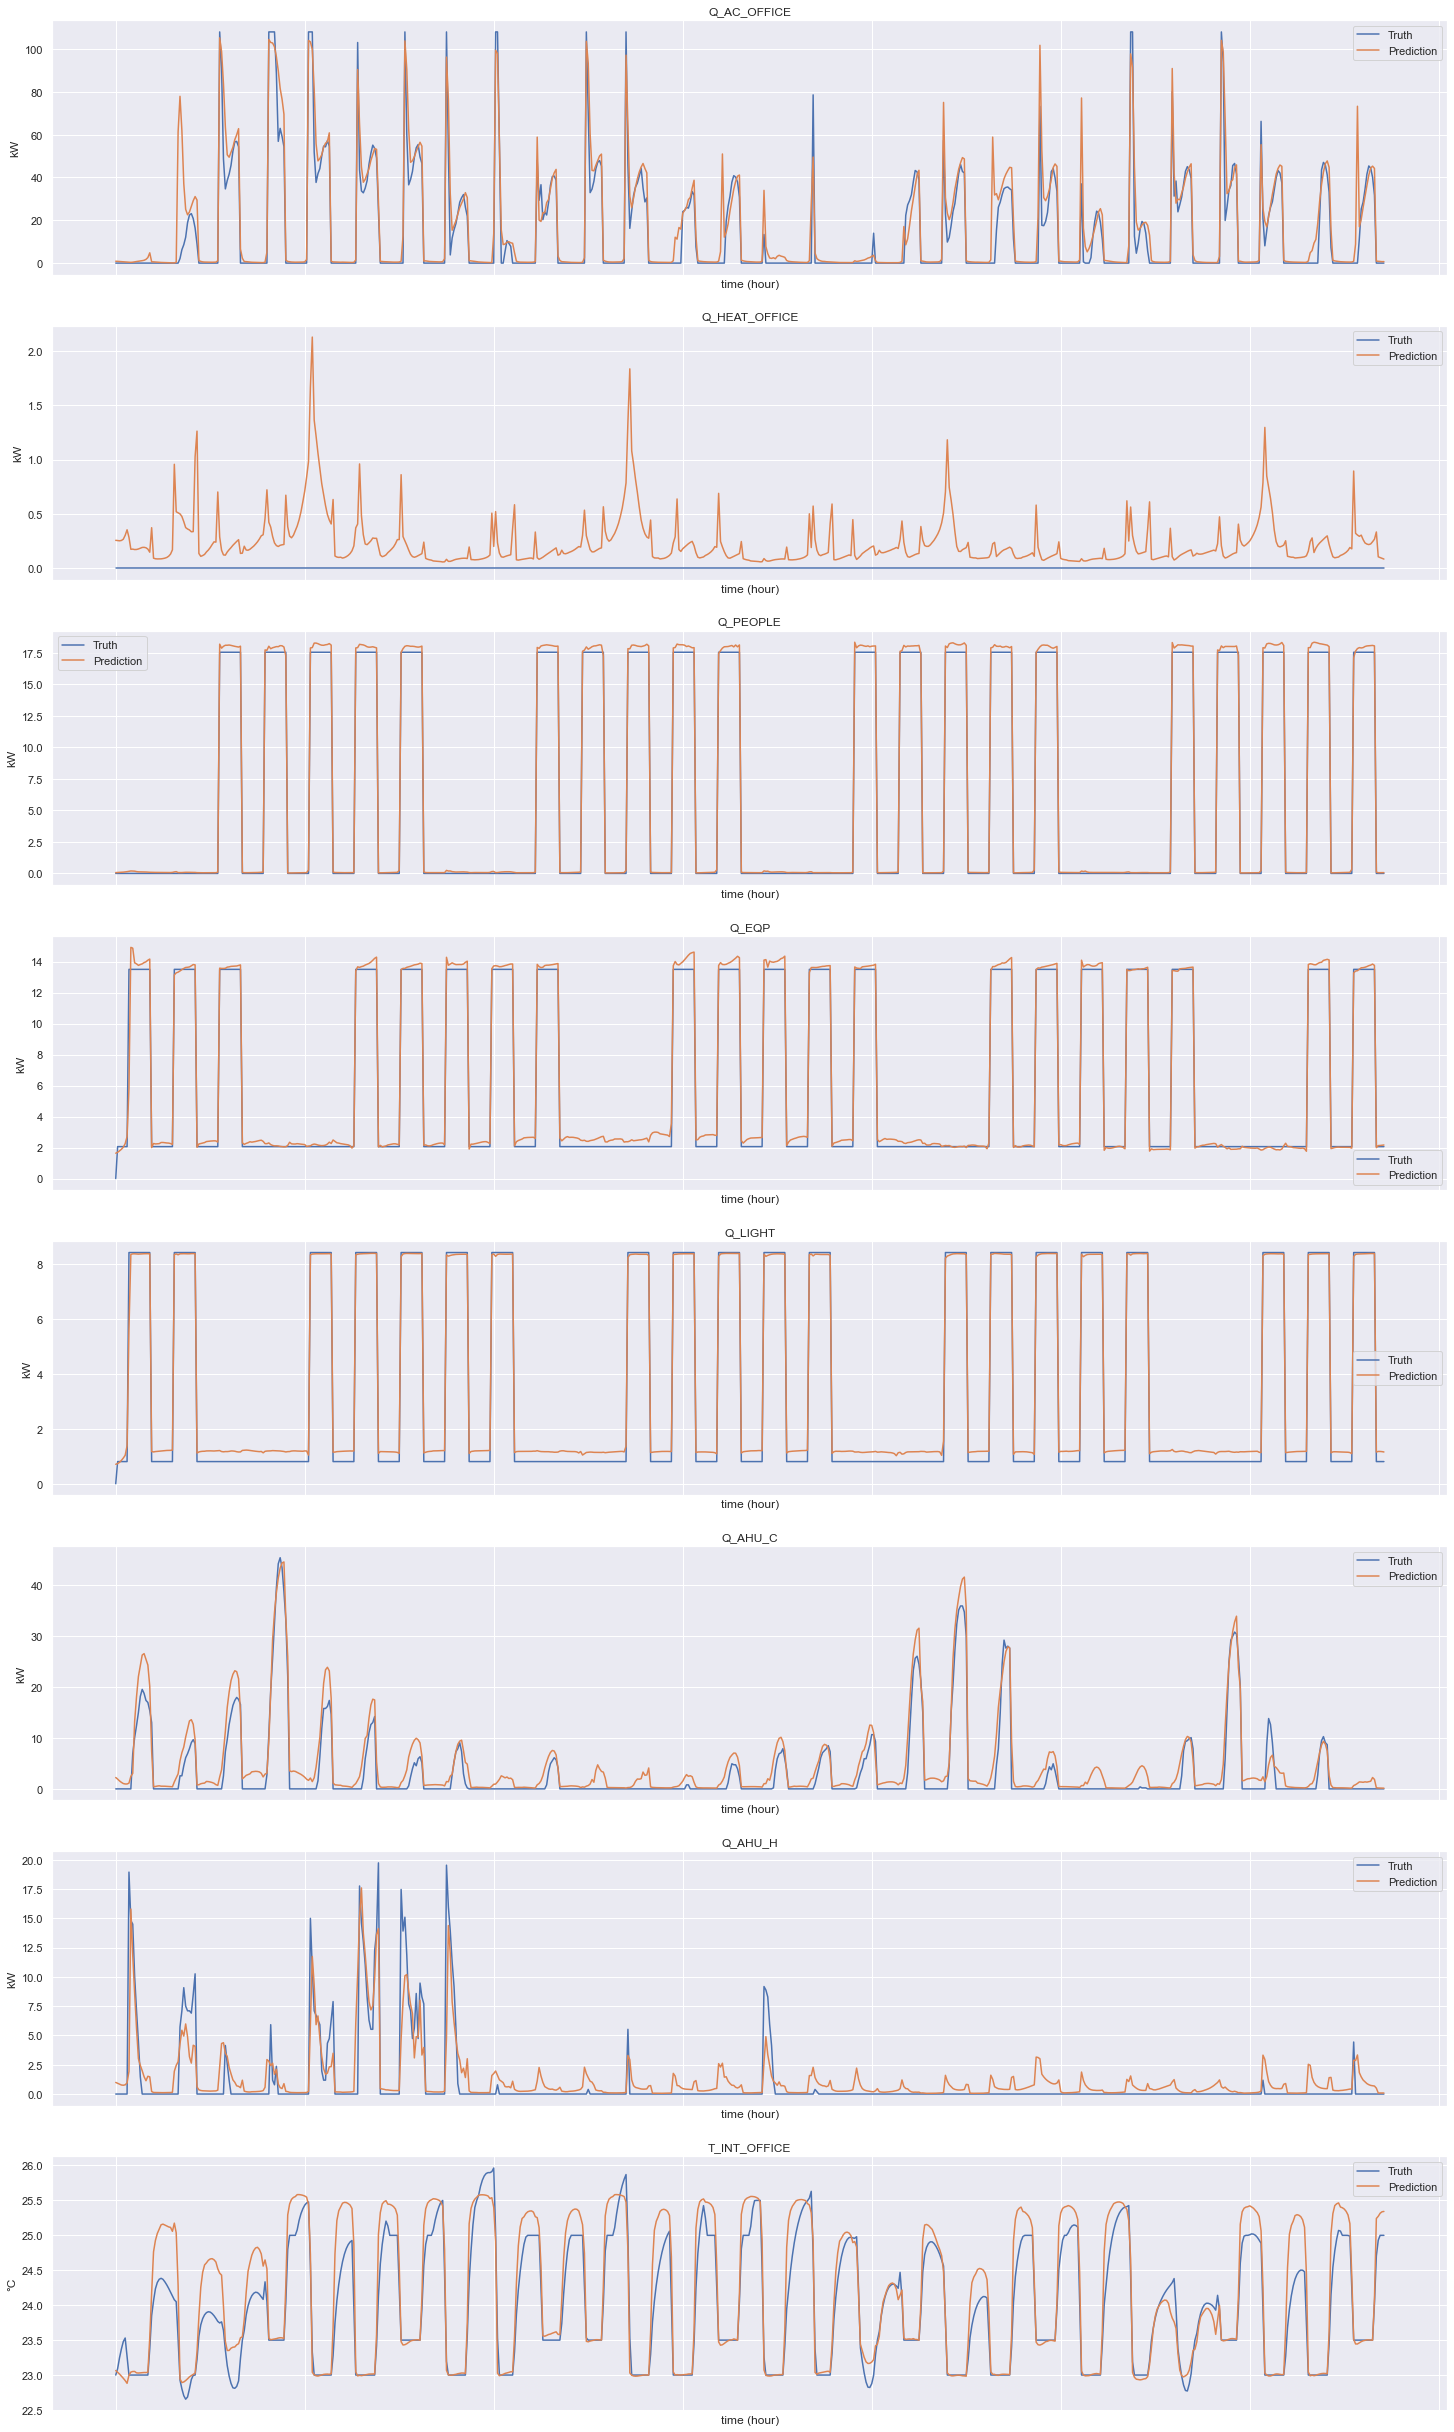

In [12]:
map_plot_function(ozeDataset, predictions, plot_visual_sample, dataset_indices=dataloader_test.dataset.indices)

### Plot error distributions

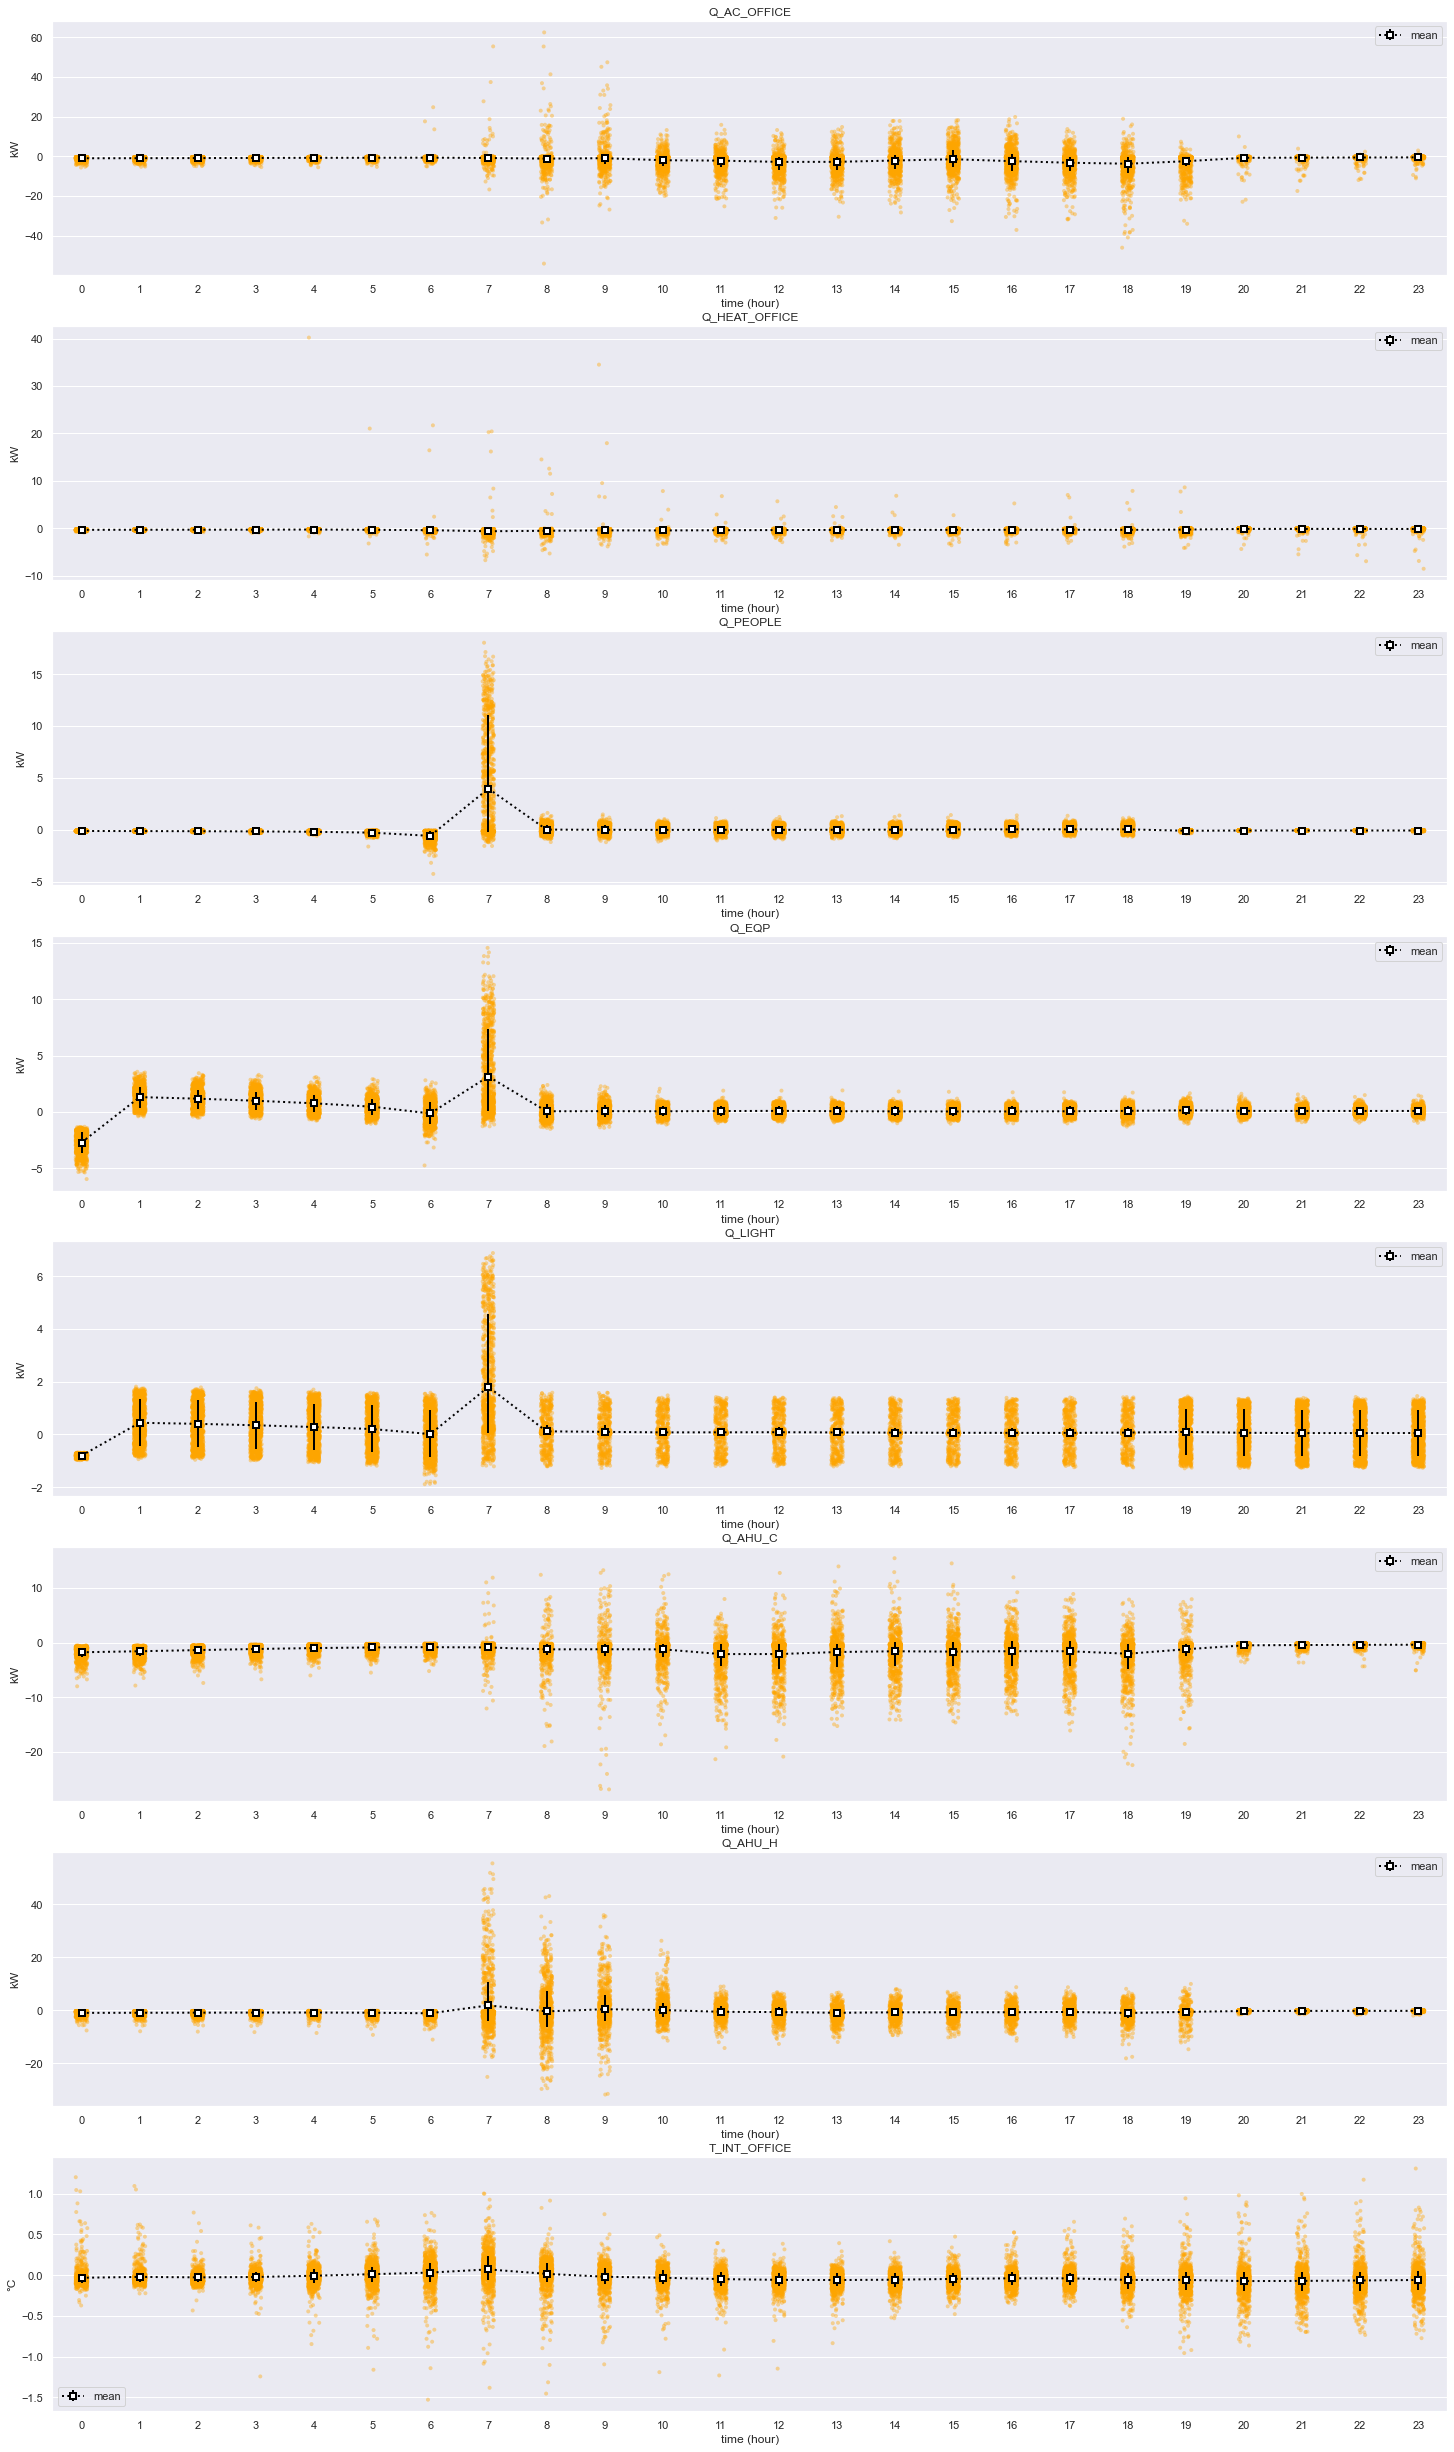

In [13]:
map_plot_function(ozeDataset, predictions, plot_error_distribution, dataset_indices=dataloader_test.dataset.indices, time_limit=24)

### Plot mispredictions thresholds

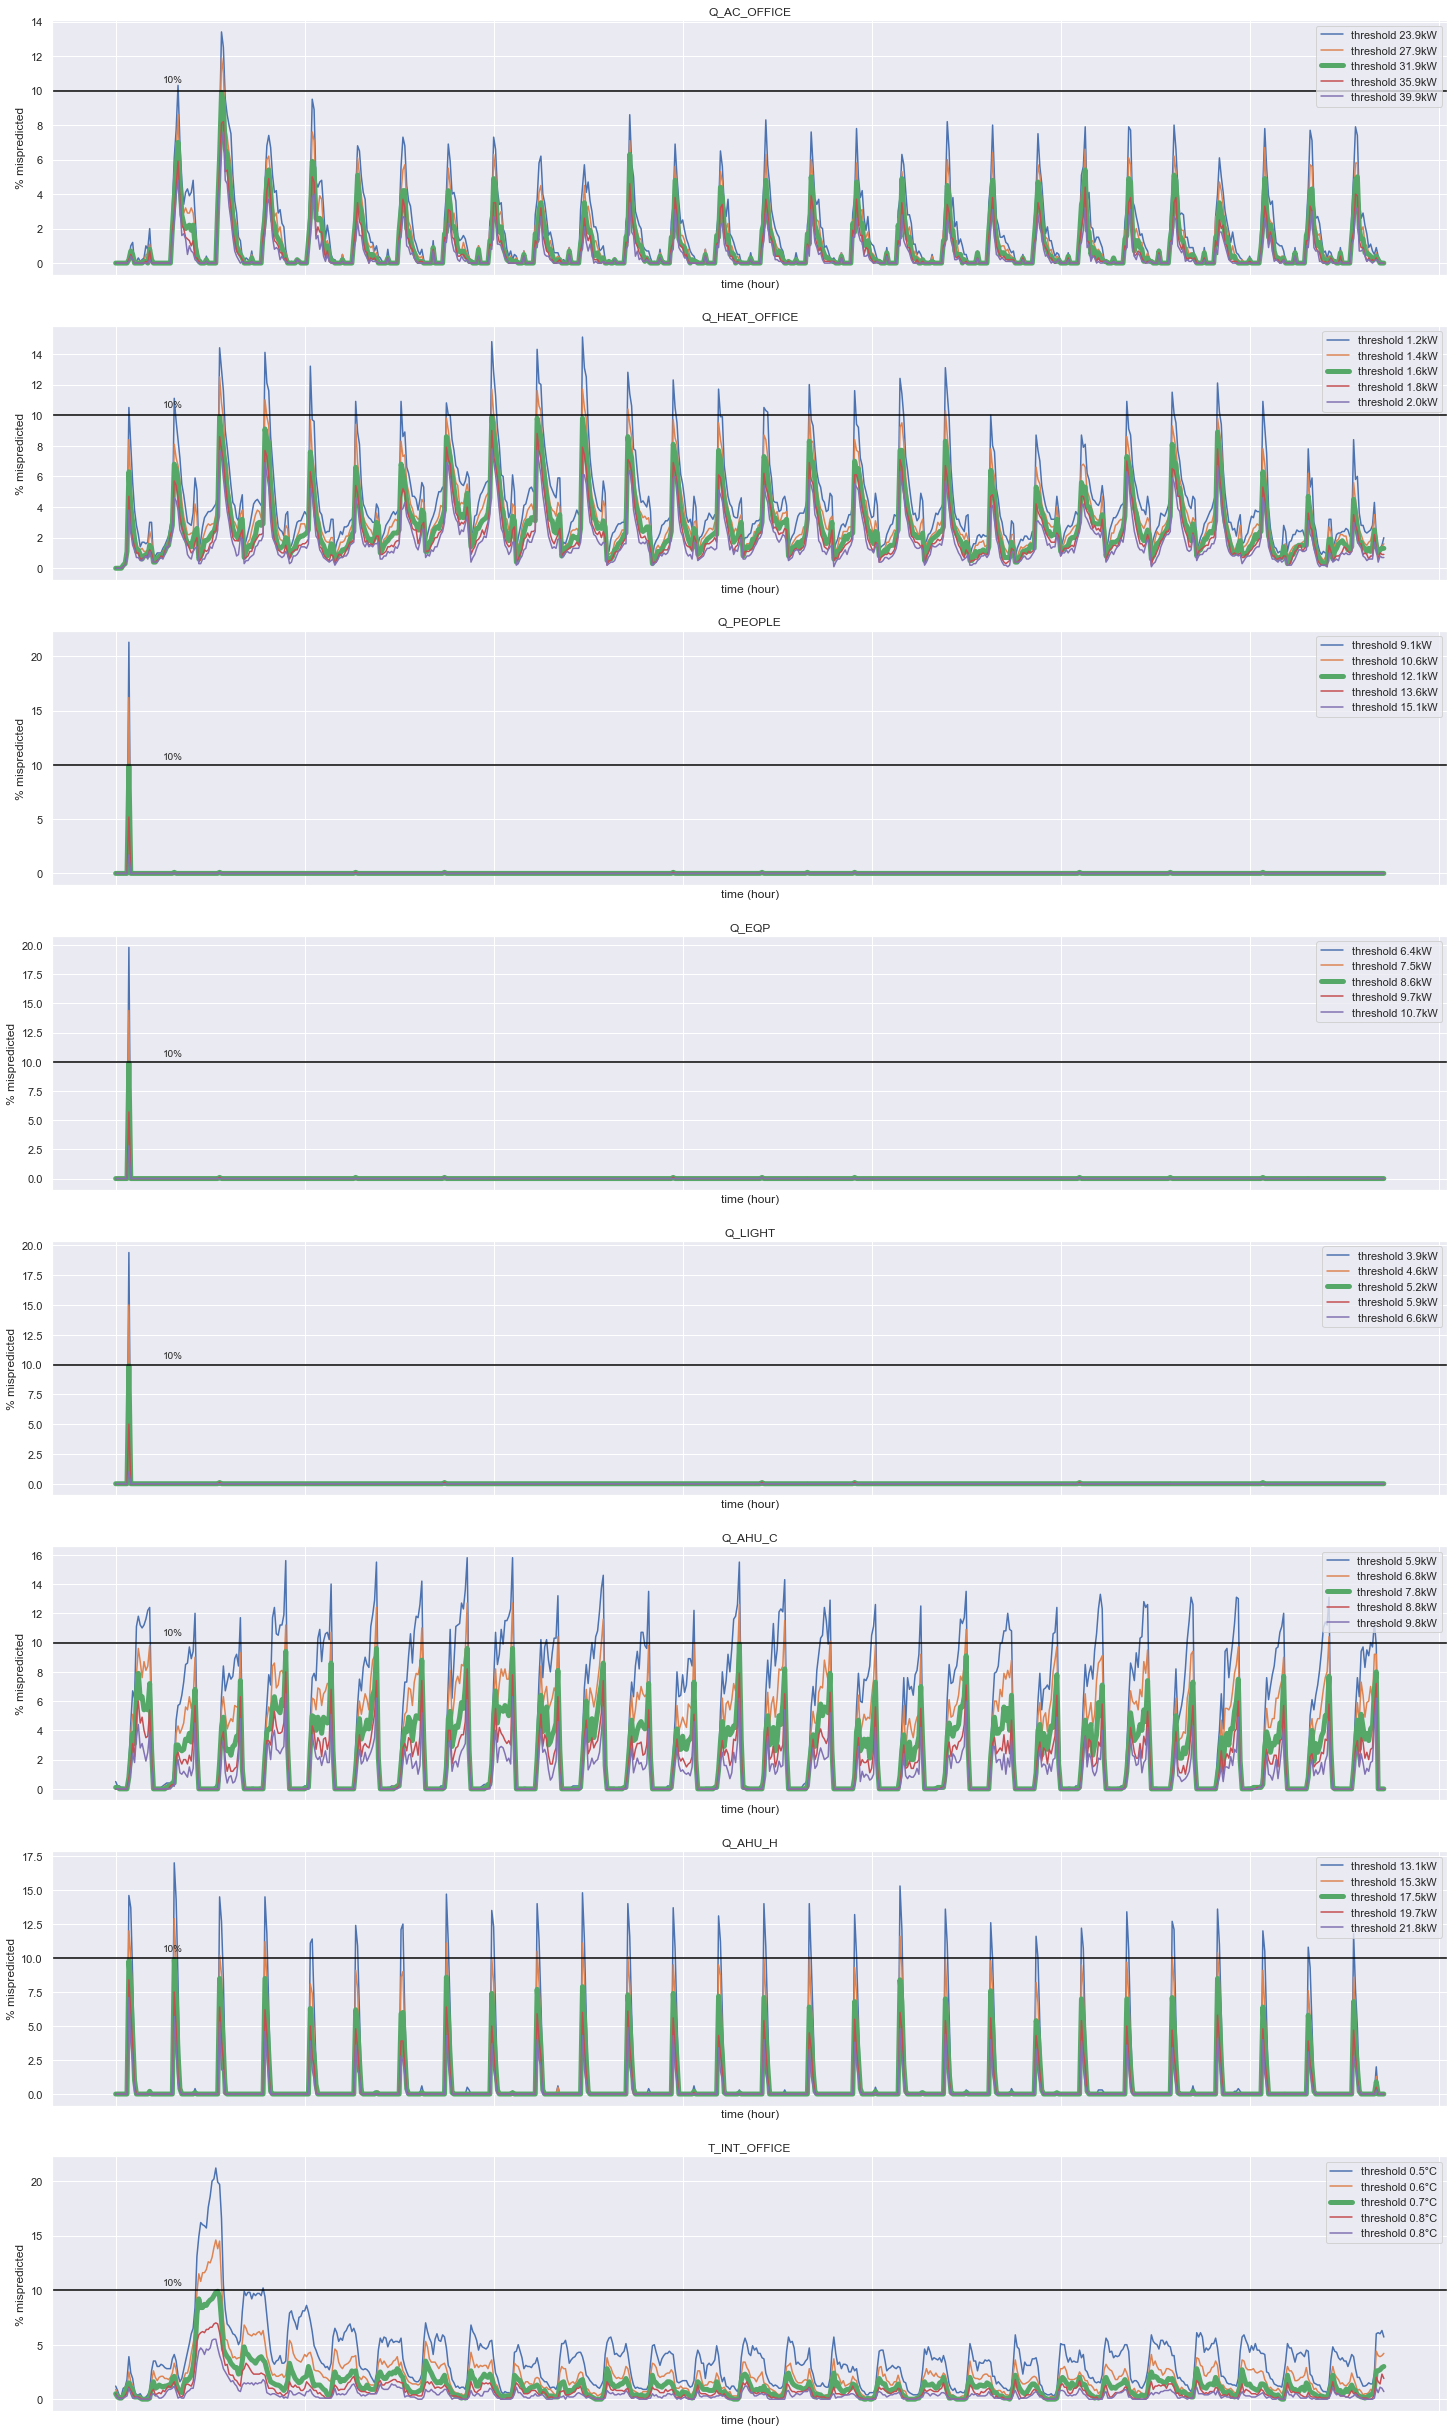

In [14]:
map_plot_function(ozeDataset, predictions, plot_errors_threshold, plot_kwargs={'error_band': 0.1}, dataset_indices=dataloader_test.dataset.indices)